This notebook offers an initial exploration into GloFAS forecast accuracy. We are comparing the reforecast product (interpolated to daily frequency) with 10 to 30-day lead time against the historical reanlysis product. 

**Note**: This notebook involves processing some of the raw data, which takes a while. For some reason it's not working for me to read in the saved processed data. Very frustrating! Problem is along [these lines](https://stackoverflow.com/questions/61585233/python-xarray-open-dataset-unable-to-read-the-second-third-or-more-nc-file). 

In [125]:
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import cfgrib
from scipy.stats import norm
import pandas as pd
import xskillscore as xs

path_mod = f"{Path(os.path.dirname(os.path.realpath(''))).parents[2]}/"
sys.path.append(path_mod)

from src.indicators.flooding import glofas
from src.bangladesh import get_glofas_data

DATA_DIR = os.environ['AA_DATA_DIR']
GLOFAS_DIR = os.path.join(DATA_DIR, 'raw', 'bangladesh', 'GLOFAS_Data')

We can define the locations of all stations of interest and set the station that we want to focus on for this analysis.

In [37]:
station = 'Bahadurabad'

FFWC_STATIONS = {
    "Noonkhawa": [89.9509, 25.9496],
    "Chilmari": [89.7476, 25.5451],
    "Bahadurabad": [89.6607, 25.1028],
    "Sariakandi": [89.6518, 24.8901],
    "Kazipur": [89.7498, 24.6637],
    "Serajganj": [89.7479, 24.4676],
    "Aricha": [89.6550, 23.9032],
    "Bahadurabad_glofas": [89.65, 25.15],

}

This code is adapted from the existing ```glofas.py```. Using here to process the raw data. Hopefully will have my issue figured out soon and can just read in the already processed data. 

In [2]:
# Stealing the functions from glofas.py

def expand_dims(
    ds: xr.Dataset, dataset_name: str, coord_names: list, expansion_dim: int
):
    """
    Using expand_dims seems to cause a bug with Dask like the one described here:
    https://github.com/pydata/xarray/issues/873 (it's supposed to be fixed though)
    """
    coords = {coord_name: ds[coord_name] for coord_name in coord_names}
    coords[coord_names[expansion_dim]] = [coords[coord_names[expansion_dim]]]
    ds = xr.Dataset(
        data_vars={
            dataset_name: (
                coord_names,
                np.expand_dims(ds[dataset_name].values, expansion_dim),
            )
        },
        coords=coords,
    )
    return ds

def _read_in_ensemble_and_perturbed_datasets(filepath_list):
        """
        Read in dataset that has both control and ensemble perturbed forecast
        and combine them
        """
        ds_list = []
        for data_type in ["cf", "pf"]:
            ds = xr.open_mfdataset(
                filepath_list,
                engine="cfgrib",
                backend_kwargs={
                    "indexpath": "",
                    "filter_by_keys": {"dataType": data_type},
                },
            )
            # Delete history attribute in order to merge
            del ds.attrs["history"]
            # Extra processing require for control forecast
            if data_type == "cf":
                ds = expand_dims(
                    ds=ds,
                    dataset_name="dis24",
                    coord_names=["number", "time", "latitude", "longitude"],
                    expansion_dim=0,
                )
            ds_list.append(ds)
        ds = xr.combine_by_coords(ds_list)
        return ds

def _get_station_dataset(stations, ds: xr.Dataset, coord_names: list) -> xr.Dataset:
        return xr.Dataset(
            data_vars={
                station_name: (
                    coord_names,
                    ds.isel(
                        latitude=np.abs(ds.latitude - lat).argmin(),
                        longitude=np.abs(ds.longitude - lon).argmin(),
                    )["dis24"],
                )
                for station_name, (lon, lat) in stations.items()
            },
            coords={coord_name: ds[coord_name] for coord_name in coord_names},
        )

To keep things simple to start, we'll process the 240h and 720h lead-time reforecasts from 1999 to 2018. We'll just focus on Bahadurabad station.

In [31]:
# Get the raw data filenames for each type of GloFAS

reforecast_dir = os.path.join(GLOFAS_DIR, 'cems-glofas-reforecast')
historical_dir = os.path.join(GLOFAS_DIR, 'cems-glofas-historical')
reforecast_0720 = [os.path.join(DATA_DIR, 'raw', 'bangladesh', 'GLOFAS_Data', 'cems-glofas-reforecast',f) for f in os.listdir(reforecast_dir) if f.endswith('lt0720.grib')]
reforecast_0240 = [os.path.join(DATA_DIR, 'raw', 'bangladesh', 'GLOFAS_Data', 'cems-glofas-reforecast',f) for f in os.listdir(reforecast_dir) if f.endswith('lt0240.grib')]
historical = [os.path.join(DATA_DIR, 'raw', 'bangladesh', 'GLOFAS_Data', 'cems-glofas-historical',f) for f in os.listdir(historical_dir) if f.endswith('.grib')]

In [16]:
# Process the reforecast (30-day and 10-day) and reanalysis (historical) data

ds_rf_0720 = _read_in_ensemble_and_perturbed_datasets(reforecast_0720)
ds_rf_0720_processed = _get_station_dataset(stations=FFWC_STATIONS, ds=ds_rf_0720, coord_names=["number", "time"])

ds_rf_0240 = _read_in_ensemble_and_perturbed_datasets(reforecast_0240)
ds_rf_0240_processed = _get_station_dataset(stations=FFWC_STATIONS, ds=ds_rf_0240, coord_names=["number", "time"])

ds_hist = xr.open_mfdataset(historical, engine="cfgrib", backend_kwargs={"indexpath": ""})
ds_hist_processed = _get_station_dataset(stations=FFWC_STATIONS, ds=ds_hist, coord_names=["time"])

In [129]:
# Select the station to focus on

sel_rf_240 = ds_rf_0240_processed[station]
sel_rf_720 = ds_rf_0720_processed[station]
sel_ra = ds_hist_processed[station]
ds_hist = ds_hist_processed[station]

In [171]:
ds_hist.time.min().values

numpy.datetime64('1979-01-01T00:00:00.000000000')

In [170]:
# Crop the time dimensions of the historical data to match the reforecasts

ds_hist.time.max().values

numpy.datetime64('2020-11-30T00:00:00.000000000')

The reforecast data isn't provided at daily intervals, so we'll do a basic interpolation to get daily forecast data.

In [119]:
# Interpolate the reforecast data to daily forecast granularity

days = (sel_rf_240.time.max().values - sel_rf_240.time.min().values).astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')

sel_rf_240_i = sel_rf_240.interp(time=pd.date_range("1999-01-01", "2018-12-30", periods=days), method='linear')
sel_rf_720_i = sel_rf_720.interp(time=pd.date_range("1999-01-01", "2018-12-30", periods=days), method='linear')

In [172]:
# Shift forecasts forward based on lead time 

da_240 = sel_rf_240_i.shift(time=10)
da_720 = sel_rf_720_i.shift(time=30)

# TODO: Crop out the earlir na's

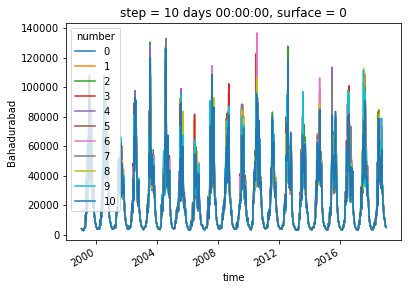

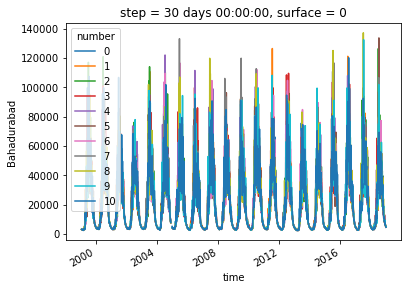

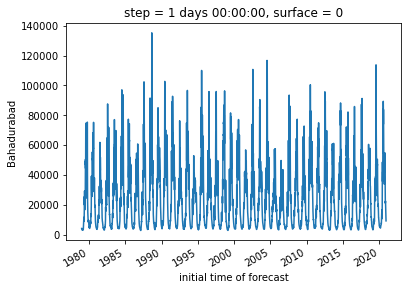

In [131]:
# Plot both of the forecasts and the historical to check that everything makes sense

da_240.plot.line(x='time')
plt.show()

da_720.plot.line(x='time')
plt.show()

ds_hist.plot.line(x='time')
plt.show()

Let's make a couple of quick comparison plots to understand what's going on with the data

In [158]:
# Get the mean value of the ensemble members and slice for closer viewing
da_240_m = da_240.mean(dim='number', keep_attrs=True).sel(time=slice('2000-05-01', '2000-08-01'))
da_720_m = da_720.mean(dim='number', keep_attrs=True).sel(time=slice('2000-05-01', '2000-08-01'))
ds_hist_m = ds_hist.sel(time=slice('2000-05-01', '2000-08-01'))

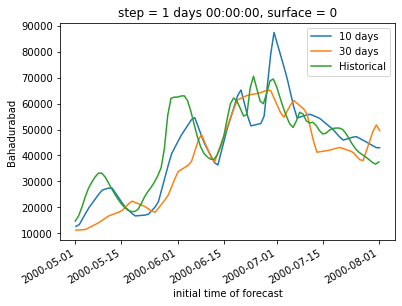

In [160]:
# Plot the 10-day, 30-day, and historical data against each other
da_240_m.plot.line(label='10 days')
da_720_m.plot.line(label='30 days')
ds_hist_m.plot.line(label='Historical')
plt.legend()
plt.show()

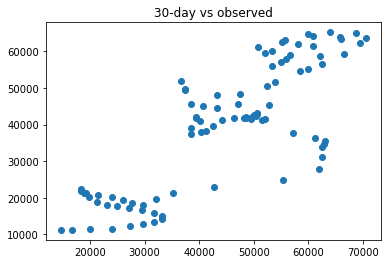

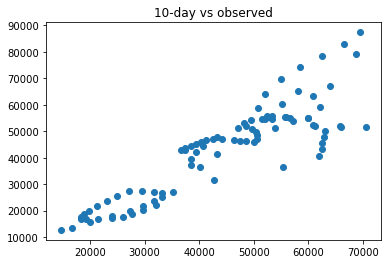

In [183]:
# Scatter plot of observed against forecasted

plt.scatter(ds_hist_m.values, da_720_m.values)
plt.title('30-day vs observed')
plt.show()

plt.scatter(ds_hist_m.values, da_240_m.values)
plt.title('10-day vs observed')
plt.show()

Let's start testing out some of the metrics from ```xskillscore```

In [161]:
obs3 = xr.DataArray(
       np.random.rand(4, 5),
       coords=[np.arange(4), np.arange(5)],
       dims=["lat", "lon"],
       name='var'
   )
fct3 = xr.DataArray(
       np.random.rand(3, 4, 5),
       coords=[np.arange(3), np.arange(4), np.arange(5)],
       dims=["member", "lat", "lon"],
       name='var'
   )

In [168]:
threshold_brier_score = xs.threshold_brier_score(ds_hist, da_240, 0.5, dim=None)
print(threshold_brier_score)

ValueError: indexes along dimension 'time' are not equal